In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import seaborn as sns

# Import the sleap_roots package
import sleap_roots as sr

from pathlib import Path

# Use the following notation to import individual functions from the sleap_roots package
from sleap_roots.points import get_all_pts_array
from sleap_roots.convhull import get_convhull, get_chull_area, get_chull_perimeter
from sleap_roots.lengths import get_root_lengths, get_curve_index
from sleap_roots.bases import get_bases, get_base_tip_dist
from sleap_roots.tips import get_tips

In [64]:
# Print sleap_roots version
print(sr.__version__)

0.0.7


In [65]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

Current directory: C:\repos\sleap-roots


In [66]:
# Use this cell if you want to change the current working directory

# Define the directory you want to change to
new_directory = "C:/repos/sleap-roots"

# Change the current working directory
os.chdir(new_directory)

# Get the updated current working directory
updated_directory = os.getcwd()

# Print the updated current working directory
print("Updated current directory:", updated_directory)


Updated current directory: C:\repos\sleap-roots


In [67]:
# Change these variables for your own data
folder_path = "tests/data/canola_7do" # Location of h5 files and predictions for dicots
primary_name = "primary" # For loading primary root predictions
lateral_name = "lateral" # For loading lateral root predictions

In [68]:
# Find all h5 files in the folder
all_h5s = sr.find_all_series(folder_path)
all_h5s

['tests/data/canola_7do/919QDUH.h5']

In [69]:
# Load the cylinder series (one per h5 file)
all_series = [sr.Series.load(h5_path=h5, primary_name=primary_name, lateral_name=lateral_name) for h5 in all_h5s]
all_series

[Series(h5_path='tests/data/canola_7do/919QDUH.h5', primary_labels=Labels(labeled_frames=72, videos=1, skeletons=1, tracks=0), lateral_labels=Labels(labeled_frames=72, videos=1, skeletons=1, tracks=0), crown_labels=None, video=Video(filename="tests/data/canola_7do/919QDUH.h5", shape=(72, 1080, 2048, 1), dataset=vol, backend=HDF5Video), csv_path=None)]

Example usage for one sample

In [70]:
# Get the first series in the list
series = all_series[0]
print(f"First sample has name {series.series_name}")
print(f"First sample video info: {series.video}")

First sample has name 919QDUH
First sample video info: Video(filename="tests/data/canola_7do/919QDUH.h5", shape=(72, 1080, 2048, 1), dataset=vol, backend=HDF5Video)


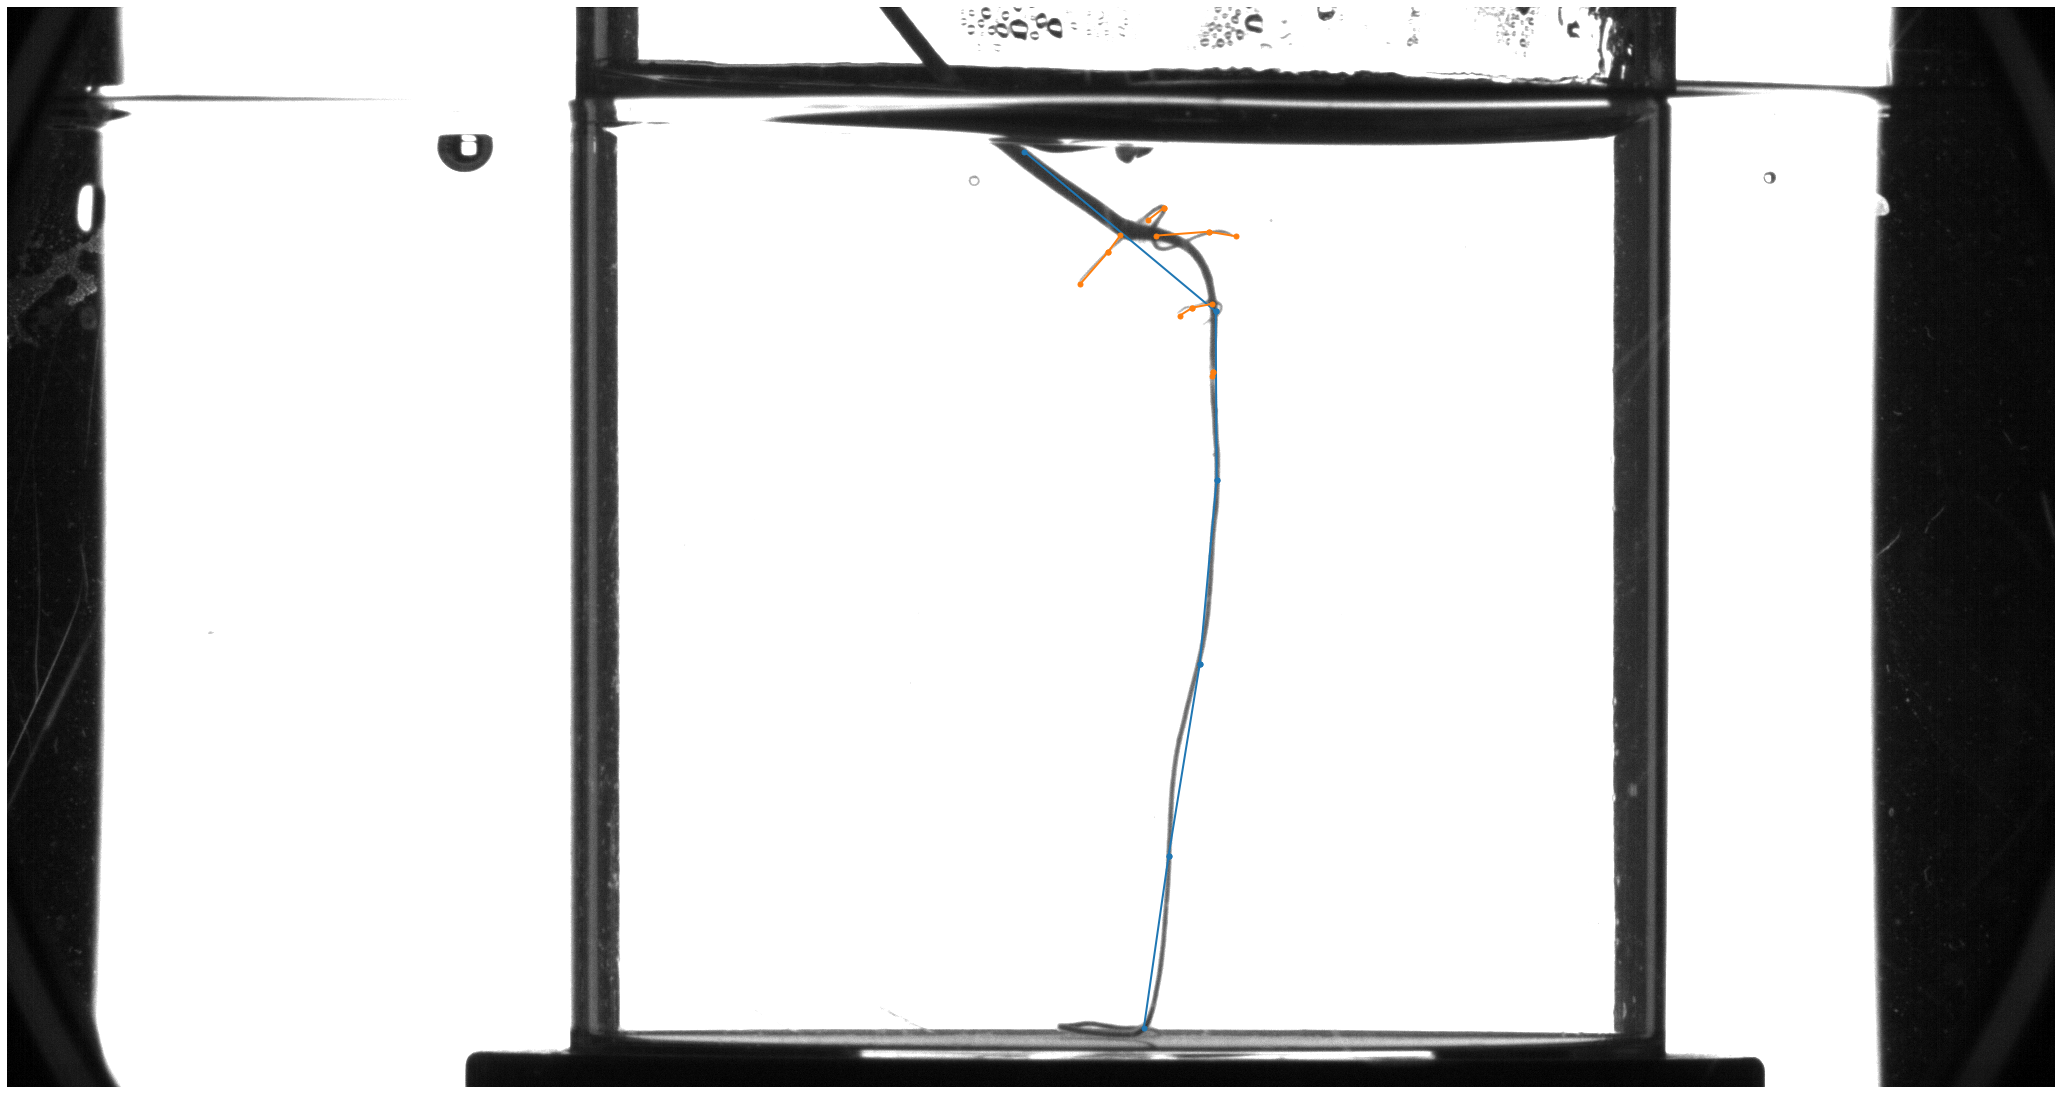

In [71]:
# Plot the first frame of the first series
series.plot(0)

In [72]:
# Get the primary root points for the first frame
primary_pts = series.get_primary_points(0)
print(f"Shape of primary points: {primary_pts.shape}")

# Get the lateral root points for the first frame
lateral_pts = series.get_lateral_points(0)
print(f"Shape of lateral points: {lateral_pts.shape}")

Shape of primary points: (1, 6, 2)
Shape of lateral points: (5, 3, 2)


In [73]:
# Get primary root lengths for the first frame
primary_lengths = get_root_lengths(primary_pts)
print(f"Primary root length of first frame is {primary_lengths} px")

# Get lateral root lengths for the first frame
lateral_lengths = get_root_lengths(lateral_pts)
print(f"Lateral root lengths shape is {lateral_lengths.shape}")

Primary root length of first frame is 971.0504174567843 px
Lateral root lengths shape is (5,)


In [74]:
# Get base point of the primary root
primary_base = get_bases(primary_pts)

# Get tip point of the primary root
primary_tip = get_tips(primary_pts)

# Get the distance between the base and tip of the primary root
base_tip_dist = get_base_tip_dist(primary_base, primary_tip)
print(f"Distance between base and tip of primary root is {base_tip_dist} px")

# Get the curve index (measure of curvature between 0 and 1) of the primary root
curve_index = get_curve_index(primary_lengths, base_tip_dist)
print(f"Curve index of primary root is {curve_index}")

Distance between base and tip of primary root is 884.6450178192455 px
Curve index of primary root is 0.08898137324716636


In [75]:
# Aggregate the primary and lateral points in one flattened array
all_pts = get_all_pts_array(primary_pts, lateral_pts)
print(f"Shape of all points: {all_pts.shape}")

# Get the convex hull of the primary and lateral points
convhull = get_convhull(all_pts)

# Get the area of the convex hull
chull_area = get_chull_area(convhull)
print(f"Area of convex hull is {chull_area} px^2")

# Get the perimeter of the convex hull
chull_perimeter = get_chull_perimeter(convhull)
print(f"Perimeter of convex hull is {chull_perimeter} px")

Shape of all points: (21, 2)
Area of convex hull is 93255.32153574759 px^2
Perimeter of convex hull is 1910.0476127930017 px


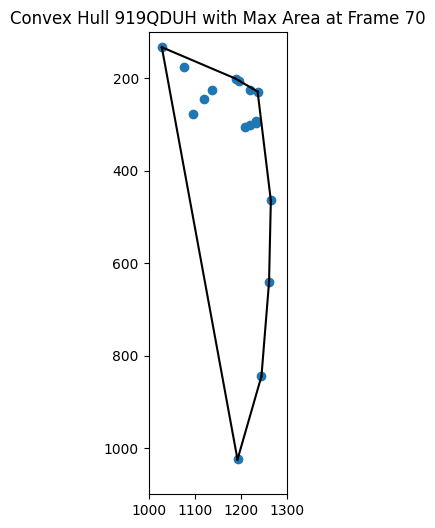

In [76]:
# Find the frame with the largest convex hull area and plot it

# Initialize lists to store the convex hull areas
hull, area = [], []

# Run convex hull features on all frames for primary and lateral roots
for i in range(len(series)):
    # Get primary root points
    primary_pts = series.get_primary_points(i)
    # Get lateral root points
    lateral_pts = series.get_lateral_points(i)
    # Aggregate the primary and lateral points in one flattened array
    all_pts = get_all_pts_array(primary_pts, lateral_pts)

    # Get the convex hull of the primary and lateral points
    convhull = get_convhull(all_pts)
    # Get the area of the convex hull
    chull_area = get_chull_area(convhull)

    # Append the convex hull and convex hull area to the lists
    hull.append(convhull)
    area.append(chull_area)

    
# Frame with the max convex hull area
idx_max_area = np.nanargmax(area)

# Plot convex hull of frame with the max width
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(hull[idx_max_area].points[:,0], hull[idx_max_area].points[:,1], 'o')
for simplex in hull[idx_max_area].simplices:
    ax.plot(hull[idx_max_area].points[simplex, 0], hull[idx_max_area].points[simplex, 1], 'k-')

plt.title(f"Convex Hull {series.series_name} with Max Area at Frame {idx_max_area}")    
plt.xlim([1000, 1300])
plt.ylim([1100, 100]) # Invert y-axis to match image coordinates
ax.set_aspect('equal')  # Set aspect ratio to 1
plt.show()



Use the `DicotPipeline` to calculate all traits

In [77]:
# Initialize the pipeline
pipeline = sr.DicotPipeline()

In [78]:
# Compute the traits for one plant
plant_traits_df = pipeline.compute_plant_traits(series, write_csv=True)

In [79]:
# Display the plant traits
plant_traits_df

,plant_name,frame_idx,root_widths_min,root_widths_max,root_widths_mean,root_widths_median,root_widths_std,root_widths_p5,root_widths_p25,root_widths_p75,...,chull_line_lengths_p75,chull_line_lengths_p95,base_length,base_median_ratio,curve_index,base_length_ratio,primary_base_tip_dist,ellipse_ratio,scanline_last_ind,scanline_first_ind
0,919QDUH,0,31.603239,31.603239,31.603239,31.603239,0.0,31.603239,31.603239,31.603239,...,550.402687,845.373983,83.699142,0.223527,0.088981,0.086194,884.645018,3.460855,46,7
1,919QDUH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,550.616202,843.208364,67.731583,0.224699,0.087357,0.069987,883.227170,3.701336,46,7
2,919QDUH,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,732.721726,863.946846,64.453796,0.229594,0.088166,0.066346,885.827768,3.515181,46,7
3,919QDUH,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,840.643234,872.443662,64.484985,0.226009,0.081440,0.067280,880.393768,3.561335,46,7
4,919QDUH,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,843.138421,871.950463,67.847366,0.230501,0.075604,0.071339,879.153473,3.859230,46,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,919QDUH,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,599.831371,815.046123,94.891190,0.214856,NaN,0.174081,NaN,3.995624,46,10
68,919QDUH,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,557.443002,803.965371,72.372955,0.250487,NaN,0.097370,NaN,3.863100,46,11
69,919QDUH,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,597.493227,809.991160,72.523636,0.222303,NaN,0.134039,NaN,3.853417,46,11
70,919QDUH,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,586.705053,801.701338,69.089523,0.252230,NaN,0.093428,NaN,4.052954,46,11


In [80]:
# Compute the traits for all plants in the folder and get summary statistics per plant
csv_path = "my_summarized_traits.csv" # Modify this path to save the summarized traits
pipeline.compute_batch_traits(all_series, write_csv=True, csv_path=csv_path)

,plant_name,root_widths_min_min,root_widths_min_max,root_widths_min_mean,root_widths_min_median,root_widths_min_std,root_widths_min_p5,root_widths_min_p25,root_widths_min_p75,root_widths_min_p95,...,scanline_last_ind_p95,scanline_first_ind_min,scanline_first_ind_max,scanline_first_ind_mean,scanline_first_ind_median,scanline_first_ind_std,scanline_first_ind_p5,scanline_first_ind_p25,scanline_first_ind_p75,scanline_first_ind_p95
0,919QDUH,15.387128,47.869479,26.576662,19.519004,11.182877,15.664252,16.233872,35.309604,43.850156,...,46.0,6,11,8.069444,7.0,1.618696,7.0,7.0,8.5,11.0
